In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle

In [3]:
from pegasos_experiment import generate_qsvm_data
from feature_maps import MediumFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer
from pegasos import pegasos

In [4]:
def hinge_loss(y_true,y_pred):
    loss = 1. - y_true*y_pred
    loss[loss < 0 ] = 0.0
    return loss


In [5]:
# blue
color_0 = '#1f77b4'
color_0_light = '#8fbbd9'

# orange
color_1 = '#ff7f0e'
color_1_light = '#ffbf86'

colors = [color_0, color_1]
colors_light = [color_0_light,color_1_light]

# other constants
lower_percentile = 0.159
upper_percentile = 0.841

plt.rcParams.update({'font.size': 24,
                     'xtick.labelsize': 20,
                     'ytick.labelsize': 20,
                     'axes.titlesize': 28,
                     'axes.labelsize': 28,
                     'mathtext.fontset': 'stix',
                     'font.family': 'STIXGeneral'})

In [6]:
margin = -0.1
Ms = 2**np.arange(6,12)
N = 1000
Cs = [10,1000]
tol = 1e-4

sep = 'separable' if margin > 0 else 'overlap'

In [7]:
y = np.array(pd.read_csv(f'data/2-qubits/{margin}_y_2048.csv')).reshape(-1)
X = np.array(pd.read_csv(f'data/2-qubits/{margin}_X_2048.csv'))

def load_data(M, seed = 42):
        assert (M <= 2048) & (M % 2 == 0)
        np.random.seed(seed)
        indices1 = np.random.randint(0,np.sum(y == 1),M//2)
        indices2 = np.random.randint(0,np.sum(y == -1),M//2)

        X1 = X[y == 1][indices1]
        y1 = y[y == 1][indices1]
        X2 = X[y == -1][indices2]
        y2 = y[y == -1][indices1]

        X12 = np.vstack([X1,X2])
        y12 = np.append(y1,y2)

        shuffle = np.random.choice(M, M, replace=False)
        return X12[shuffle], y12[shuffle]

In [8]:
# Feature map for the experiment
feature_map = MediumFeatureMap(2,4)

# Kernel
adhoc_backend = QuantumInstance(Aer.get_backend('statevector_simulator'))
adhoc_kernel = QuantumKernel(feature_map=feature_map.get_reduced_params_circuit(), quantum_instance=adhoc_backend)

np.random.seed(41)
seeds = np.random.randint(0,10000,10)
dtypes = {'seed': int, 'C' : int, 'M' : int}
# Checking whether experiment has already been partially done and loading existing data
try:
    results = pd.read_csv(f'data/M_{margin}_data.csv',dtype=dtypes)
except:
    columns = ['seed','C','M']
    results = pd.DataFrame(columns=columns)
    results.to_csv(f'data/M_{margin}_data.csv',index=False)

for C in Cs[::-1]:
    for M in tqdm(Ms):
        if ((results['M'] == M) & (results['C'] == C)).any():
            print(f'Found M {M}')
            continue
        # Creating artificial data
        X,y = load_data(M)
        K = adhoc_kernel.evaluate(X)
        for s in seeds:
            y_preds, _,_,_ = pegasos(K,y,N,C,seed=s,full_returns=True)
            losses = [np.mean(hinge_loss(y,yp)) for yp in y_preds]
            pickle.dump(losses,open(f'data/dumps/M_dependence_{s}_C_{C}_M_{M}_{margin}.pkl','wb'))
            results.loc[results.shape[0]] = [s,C,M]
            results.to_csv(f'data/M_{margin}_data.csv',index=False)

100%|██████████| 6/6 [00:00<00:00, 1147.03it/s]


Found M 64
Found M 128
Found M 256
Found M 512
Found M 1024
Found M 2048


100%|██████████| 6/6 [00:00<00:00, 1896.30it/s]

Found M 64
Found M 128
Found M 256
Found M 512
Found M 1024
Found M 2048


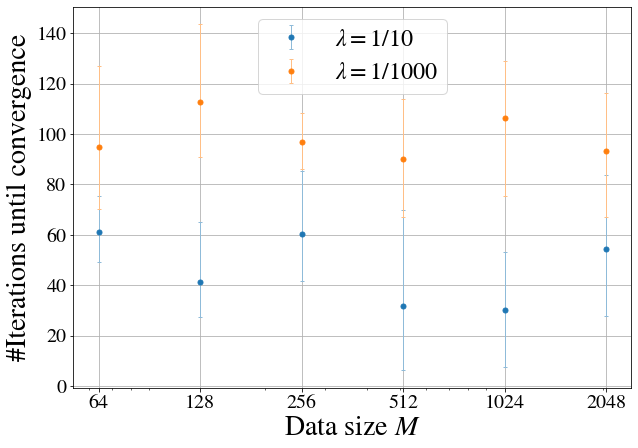

In [24]:
plt.figure(figsize=(10,7))
for k, C in enumerate([10,1000]):
    convergence_after = np.zeros((len(Ms),len(seeds)))
    for i, M in enumerate(Ms):
        for j, s in enumerate(seeds):
            filename = f'data/dumps/M_dependence_{s}_C_{C}_M_{M}_{margin}.pkl'
            hinges = np.array(pickle.load(open(filename,'rb')))
            diff = np.abs(hinges[1:] - hinges[:-1])
            convergence_after[i,j] = np.where(diff < 1e-3)[0][0]

    means = np.mean(convergence_after,axis=1)
    upper = np.quantile(convergence_after, upper_percentile, axis=1)
    lower = np.quantile(convergence_after,lower_percentile,axis=1)
    errors = np.array([means - lower, upper - means])
    
    plt.errorbar(Ms,means,yerr=errors,label=r'$\lambda = 1/{{%s}}$'%int(C),marker='.',ecolor=colors_light[k],elinewidth=1.,ls='',capsize=2,
            color=colors[k], ms=10)

plt.xscale('log')
plt.xticks(Ms,Ms)
plt.grid()
if margin < 0:
    plt.legend()
plt.ylabel('#Iterations until convergence')
plt.xlabel(r'Data size $M$')
plt.savefig(f'plots/pegasos_M_{sep}.png',dpi=300,bbox_inches='tight')

In [10]:
X_,y_ = load_data(256)
K_ = adhoc_kernel.evaluate(X_)

In [11]:
from sklearn.svm import SVC
svc = SVC(kernel='precomputed',C=10)
svc.fit(K_,y_)
h = svc.decision_function(K_)

In [17]:
from shot_based_kernel import ShotBasedQuantumKernel
shots_kernel = ShotBasedQuantumKernel(K_)
K_R = shots_kernel.approximate_kernel(10024)

In [18]:
svc_R = SVC(kernel='precomputed',C=10)
svc_R.fit(K_R,y_)
h1 = svc_R.decision_function(K_R)
h2 = svc_R.decision_function(K_)

In [19]:
eps1 = np.max(np.abs(h-h1))
eps2 = np.max(np.abs(h-h2))
print(eps1,eps2)

2.231480340261454 1.2196903513718809
